# LightGBM for prediction

## Load pre-processed data

In [1]:
import numpy as np
import pandas as pd

import basic_application_data_cleaner as cleaner

import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
path_to_kaggle_data='~/kaggle_JPFGM/Data/'  # location of all the unzipped data files on local machine

# cleaned application data (truncated outliers, imputed missing values, one-hot-encoded categorical features)
df_train, df_test = cleaner.load_cleaned_application_data(path_to_kaggle_data)

Raw training data size: (307511, 121)
Raw test data size: (48744, 120)
Cleaned training data shape:  (307511, 246)
Cleaned testing data shape:  (48744, 245)


## Create train and validation sets

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def create_train_val_set(train_data, frac_eval):
    """Create separate training and testing features and labels.
    
    Parameters
    ----------
    train_data: pandas dataframe with 'TARGET' column and feature columns (and SK_ID index)
    frac_eval: between 0 and 1. Fraction of data to be split for evaluation
    """
    X = train_data.drop(['TARGET'], axis=1)
    y = train_data['TARGET']
    
    # Create train and validation sets in stratified way
    print('Creating training and validation dataframes:')
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=frac_eval, stratify=y, random_state=42)
    print('\ttraining data size:', X_train.shape)
    print('\ttesting data size:', X_val.shape)
    print('\tpositive labels in training data: %.4f%%' % (100*sum(y_train==1)/len(y_train)))
    print('\tpositive labels in validation data: %.4f%%' % (100*sum(y_val==1)/len(y_val)))
    return X_train, X_val, y_train, y_val

In [5]:
# split cleaned data set
X_train, X_val, y_train, y_val = create_train_val_set(df_train, 0.1)

Creating training and validation dataframes:
	training data size: (276759, 245)
	testing data size: (30752, 245)
	positive labels in training data: 8.0727%
	positive labels in validation data: 8.0743%


## Fit LightGBM model on pre-processed data

In [6]:
import time

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

### Simple LightGBM model
Attention: lightgbm.LGBMClassifier by default does not do regularization

In [42]:
# Train sklearn wrapper lgb, with reasonable parameters and early stopping
# this runs very fast (seconds for 100 n_estimators)
lgb_clf = lgb.LGBMClassifier(objective='binary',
                             is_unbalance=True,
                             silent=True,
                             reg_lambda=1
                            )  # by default trains 100 trees

lgb_clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='auc',
            early_stopping_rounds=10,
            verbose=10)

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.747937	valid_1's auc: 0.736244
[20]	training's auc: 0.756918	valid_1's auc: 0.744184
[30]	training's auc: 0.764791	valid_1's auc: 0.749783
[40]	training's auc: 0.770787	valid_1's auc: 0.753265
[50]	training's auc: 0.775708	valid_1's auc: 0.755417
[60]	training's auc: 0.779898	valid_1's auc: 0.756681
[70]	training's auc: 0.78376	valid_1's auc: 0.757713
[80]	training's auc: 0.787305	valid_1's auc: 0.758531
[90]	training's auc: 0.790421	valid_1's auc: 0.758647
Early stopping, best iteration is:
[84]	training's auc: 0.788654	valid_1's auc: 0.758782


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        is_unbalance=True, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Grid Search Parameters

To use sklearn's gridsearch function, need to use sklearn wrapper for lightGB
Attention: grid search takes a long time to run!

In [45]:
# Grid search with cross validation on all labelled data
model = lgb.LGBMClassifier(objective='binary', is_unbalance=True, silent=True)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [40, 100],
    'reg_lambda': [0.1, 1]
}

grid_clf = GridSearchCV(model,
                        param_grid,
                        scoring='roc_auc',
                        verbose=0,
                        cv=4,
                        n_jobs=2)

grid_clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        is_unbalance=True, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'learning_rate': [0.01, 0.1, 1], 'n_estimators': [40, 100], 'reg_lambda': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
print('Best parameters found by grid search are:', grid_clf.best_params_)
print('Best score found by grid search is:', grid_clf.best_score_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 100, 'reg_lambda': 1}
Best score found by grid search is: 0.7554568161384894


## Early stopping and CV with efficient lgb data structure

In [9]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [92]:
# Set hyperparameters other than number of boosting rounds
param={'application': 'binary',  # for binary classification problem
    'boosting': 'gbdt',  # traditional Gradient Boosting Decision Tree
    'objective': 'binary',   # for binary classification problem
    'metric': ['binary_logloss', 'auc'],  # metrics to output each round
    #'is_unbalance': 'true',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    #'bagging_freq': 10,
    'learning_rate': 0.01,
    'num_leaves': 20, # default 31. lower to control overfitting
    'reg_alpha': 5,
    'reg_lambda': 10,
    'verbose': 0
}

TODO:
- check whether can use built-in cross validation on X_train for selecting early stopping round, instead of using the validation set. Then check performance on X_val in the end.
- Can combine early stopping with grid search? either by putting early stopping into the model defined in grid search or by doing parameter search in lgb.train

In [93]:
# Early stopping for fixed set of parameters

evals_result = {}
start = time.time()

gbm = lgb.train(param,
                lgb_train,
                num_boost_round=300,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['train', 'val'],
                evals_result=evals_result,
                early_stopping_rounds=20,
                verbose_eval=5)

end = time.time()
print('Execution time:', np.round(end - start, 1), 'seconds')

Training until validation scores don't improve for 20 rounds.
[5]	train's auc: 0.725438	train's binary_logloss: 0.278583	val's auc: 0.719865	val's binary_logloss: 0.278618
[10]	train's auc: 0.727428	train's binary_logloss: 0.276491	val's auc: 0.722651	val's binary_logloss: 0.276569
[15]	train's auc: 0.730978	train's binary_logloss: 0.27476	val's auc: 0.726307	val's binary_logloss: 0.274868
[20]	train's auc: 0.73114	train's binary_logloss: 0.27313	val's auc: 0.726134	val's binary_logloss: 0.273285
[25]	train's auc: 0.730882	train's binary_logloss: 0.271546	val's auc: 0.725713	val's binary_logloss: 0.271736
[30]	train's auc: 0.732583	train's binary_logloss: 0.270251	val's auc: 0.727236	val's binary_logloss: 0.27048
[35]	train's auc: 0.733659	train's binary_logloss: 0.269055	val's auc: 0.728154	val's binary_logloss: 0.269318
[40]	train's auc: 0.73364	train's binary_logloss: 0.26786	val's auc: 0.727995	val's binary_logloss: 0.268168
[45]	train's auc: 0.734054	train's binary_logloss: 0.2667

In [90]:
# Evaluation of early stopping best model on validation set
y_score = gbm.predict(X_val, num_iteration=gbm.best_iteration)  # outputs continuous score
roc_auc_score(y_val, y_score)

0.744932847418283

In [20]:
# Cross validated performance of lgb boosting rounds
lgb.cv(param, lgb_train, num_boost_round=10, nfold=5)

{'auc-mean': [0.707965273741698,
  0.7132062081864082,
  0.7175145246041219,
  0.7201859714305676,
  0.7219206227752515,
  0.7246370368066001,
  0.7260307805186594,
  0.72745827958041,
  0.7290081908087878,
  0.7302142710633293],
 'auc-stdv': [0.0034606242499253355,
  0.004106813522897233,
  0.0039085737919445735,
  0.003241465580349089,
  0.0033840200741139296,
  0.0034428273371445665,
  0.003622890868278302,
  0.0034761383850452463,
  0.0032639349121020215,
  0.0032887573943964714]}

## Examine output

Plot feature importances...


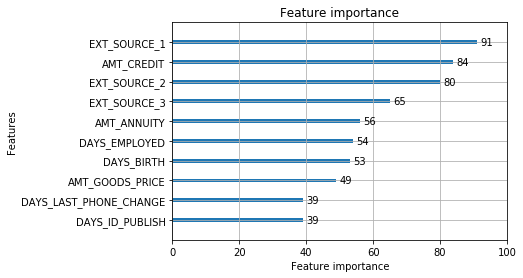

In [77]:
print('Plot feature importances...')
lgb.plot_importance(gbm, max_num_features=10)
plt.show()